Goal: from human data, train an AI to predict cards to pick at card rewards or shops.

Refer to README.md for the installation.

# Create dataset

Requires official .run files. One .run represents one game of STS. From .run files, we try to reconstruct the deck state at each floor. This allows us to build a labeled dataset of (deck state, offered cards, picked cards).

In the official 'SlayTheData' dataset, several .run files are concatenated into .json files.

In [1]:
from sts_ml.deck_history import compile_datas, create_dataset

In [ ]:
compile_datas()

In [2]:
create_dataset("SlayTheData_win_a10+_ic_64298.json", debug_end_idx=50)

10: diff = 1 ; to add = [] ; to remove = [] ; to upgrade = ['feed']
12: diff = 1 ; to add = ['demonform'] ; to remove = [] ; to upgrade = []
13: diff = 1 ; to add = [] ; to remove = ['strike_r+1'] ; to upgrade = []
14: diff = 2 ; to add = ['strike_r'] ; to remove = ['strike_r+1'] ; to upgrade = []
21: diff = 1 ; to add = ['clumsy'] ; to remove = [] ; to upgrade = []
23: diff = 1 ; to add = ['offering'] ; to remove = [] ; to upgrade = []
26: diff = 1 ; to add = ['parasite'] ; to remove = [] ; to upgrade = []
31: diff = 1 ; to add = ['battletrance'] ; to remove = [] ; to upgrade = []
32: diff = 5 ; to add = ['doubt', 'injury', 'demonform+1', 'immolate+1'] ; to remove = [] ; to upgrade = ['darkembrace']
33: diff = 1 ; to add = ['impervious'] ; to remove = [] ; to upgrade = []
34: diff = 1 ; to add = ['demonform'] ; to remove = [] ; to upgrade = []
39: diff = 4 ; to add = ['feelnopain', 'disarm'] ; to remove = ['strike_r'] ; to upgrade = ['perfectedstrike']
41: diff = 3 ; to add = [] ; to 

# 'card predictor' model

## Train 'card predictor' model

We ask a model to learn from the dataset. The Neural Net that we use is based on Multi Head Attention, which allows to have a model that can semantically well represent decks and prompts of various sizes. Especially, this is in principle better than averaging all embeddings as done in https://github.com/alexdriedger/SlayTheSpireFightPredictor.

In [1]:
from sts_ml.train import train, pursue_training

In [2]:
train()

Train (1032281) / validation (258071) ratio = 0.8
{'epoch': 0, 'training_cross_ent_loss': 2.433920383453369, 'training_top_inf_acc': 0.5190103054046631, 'training_top_true_acc': 0.7223958373069763, 'training_top_1_acc': 0.7240000367164612, 'val_cross_ent_loss': 1.7075797319412231, 'val_top_inf_acc': 0.28613269329071045, 'val_top_true_acc': 0.666015625, 'val_top_1_acc': 0.6600000262260437}
{'epoch': 1, 'training_cross_ent_loss': 1.931317925453186, 'training_top_inf_acc': 0.30079197883605957, 'training_top_true_acc': 0.70703125, 'training_top_1_acc': 0.7040000557899475, 'val_cross_ent_loss': 1.6764578819274902, 'val_top_inf_acc': 0.2025931477546692, 'val_top_true_acc': 0.62109375, 'val_top_1_acc': 0.612000048160553}
{'epoch': 2, 'training_cross_ent_loss': 1.7219983339309692, 'training_top_inf_acc': 0.21813590824604034, 'training_top_true_acc': 0.66796875, 'training_top_1_acc': 0.66796875}


## Load model and try on custom data

In [1]:
import os
import json

from sts_ml.train import Model, TRAINING_DIR, load_datasets, PARAMS_FILENAME
from sts_ml.infer import plot_training_metrics, generate_metrics

model_name = "2023-02-02-21-40-52_blocks4-256_split0.8_relics"

training_dir = os.path.join(TRAINING_DIR, model_name)
model = Model.load_model(training_dir, ckpt=1728)


One may input any list of relics, cards, and offered cards to see the result. Offered cards may be put either into 'cards_picked' or 'cards_skipped', this won't affect the predicted scores here.

In [2]:
sample = {
    'relics': [
        'omamori',
    ],
    'deck': [
        'defend_r',
        'defend_r',
        'defend_r',
        'defend_r+1',
        'strike_r',
        'strike_r',
        'bash',
        'ascendersbane',
        'havoc+1',
        'recklesscharge+1',
        'rampage',
        'headbutt',
        'shrugitoff',
        'feelnopain',
        'impervious',
        'brutality+1',
        'feed',
        'shrugitoff+1',
        'truegrit+1',
    ],
    'cards_picked': [
    ],
    'cards_skipped': [
        # 'ironwave',
        # 'combust',
        # 'bodyslam',
        # 'perfectedstrike',
        # 'twinstrike',
        # 'sentinel',
        # 'darkembrace',
        # 'cleave',
        # 'swordboomerang',
        # 'carnage',
        # 'searingblow',
        # 'flex',
        # 'warcry',
        # 'powerthrough',
        # 'rupture',
        # 'rampage',
        # 'thunderclap',
        # 'doubletap',
        # 'limitbreak+1',
        # 'berserk',
        # 'headbutt',
        # 'inflame',
        'feed',
        'armaments+1',
        'pommelstrike',
    ],
}
model.predict_one(sample)


               cards expert_scores predicted_scores
0           defend_r          deck             deck
1           defend_r          deck             deck
2           defend_r          deck             deck
3         defend_r+1          deck             deck
4           strike_r          deck             deck
5           strike_r          deck             deck
6               bash          deck             deck
7      ascendersbane          deck             deck
8            havoc+1          deck             deck
9   recklesscharge+1          deck             deck
10           rampage          deck             deck
11          headbutt          deck             deck
12        shrugitoff          deck             deck
13        feelnopain          deck             deck
14        impervious          deck             deck
15       brutality+1          deck             deck
16              feed          deck             deck
17      shrugitoff+1          deck             deck
18        tr

## Load model and try on the test dataset

In [1]:
import os
import json

from sts_ml.train import TRAINING_DIR, PARAMS_FILENAME
from sts_ml.model import CardModel
from sts_ml.infer import plot_training_metrics, generate_metrics

model_name = "2023-02-02-21-40-52_blocks4-256_split0.8_relics"

training_dir = os.path.join(TRAINING_DIR, model_name)
model = CardModel.load_model(training_dir, ckpt=1728)


A bit of explanantion about the metrics:
- top_1_acc is the most relevant in term of what matters to a player, most of the time. From the graph, one should read that 0.40 corresponds to **1 - 0.40 = 60% accuracy**. It is evaluted only on samples where only 1 card was obtained (in .run files this corresponds to fight floors (because the additional reward from Prayer Wheel is not logged), and shops where at most 1 card was bought).
- cross_ent_loss is the training loss that is used for backpropagation

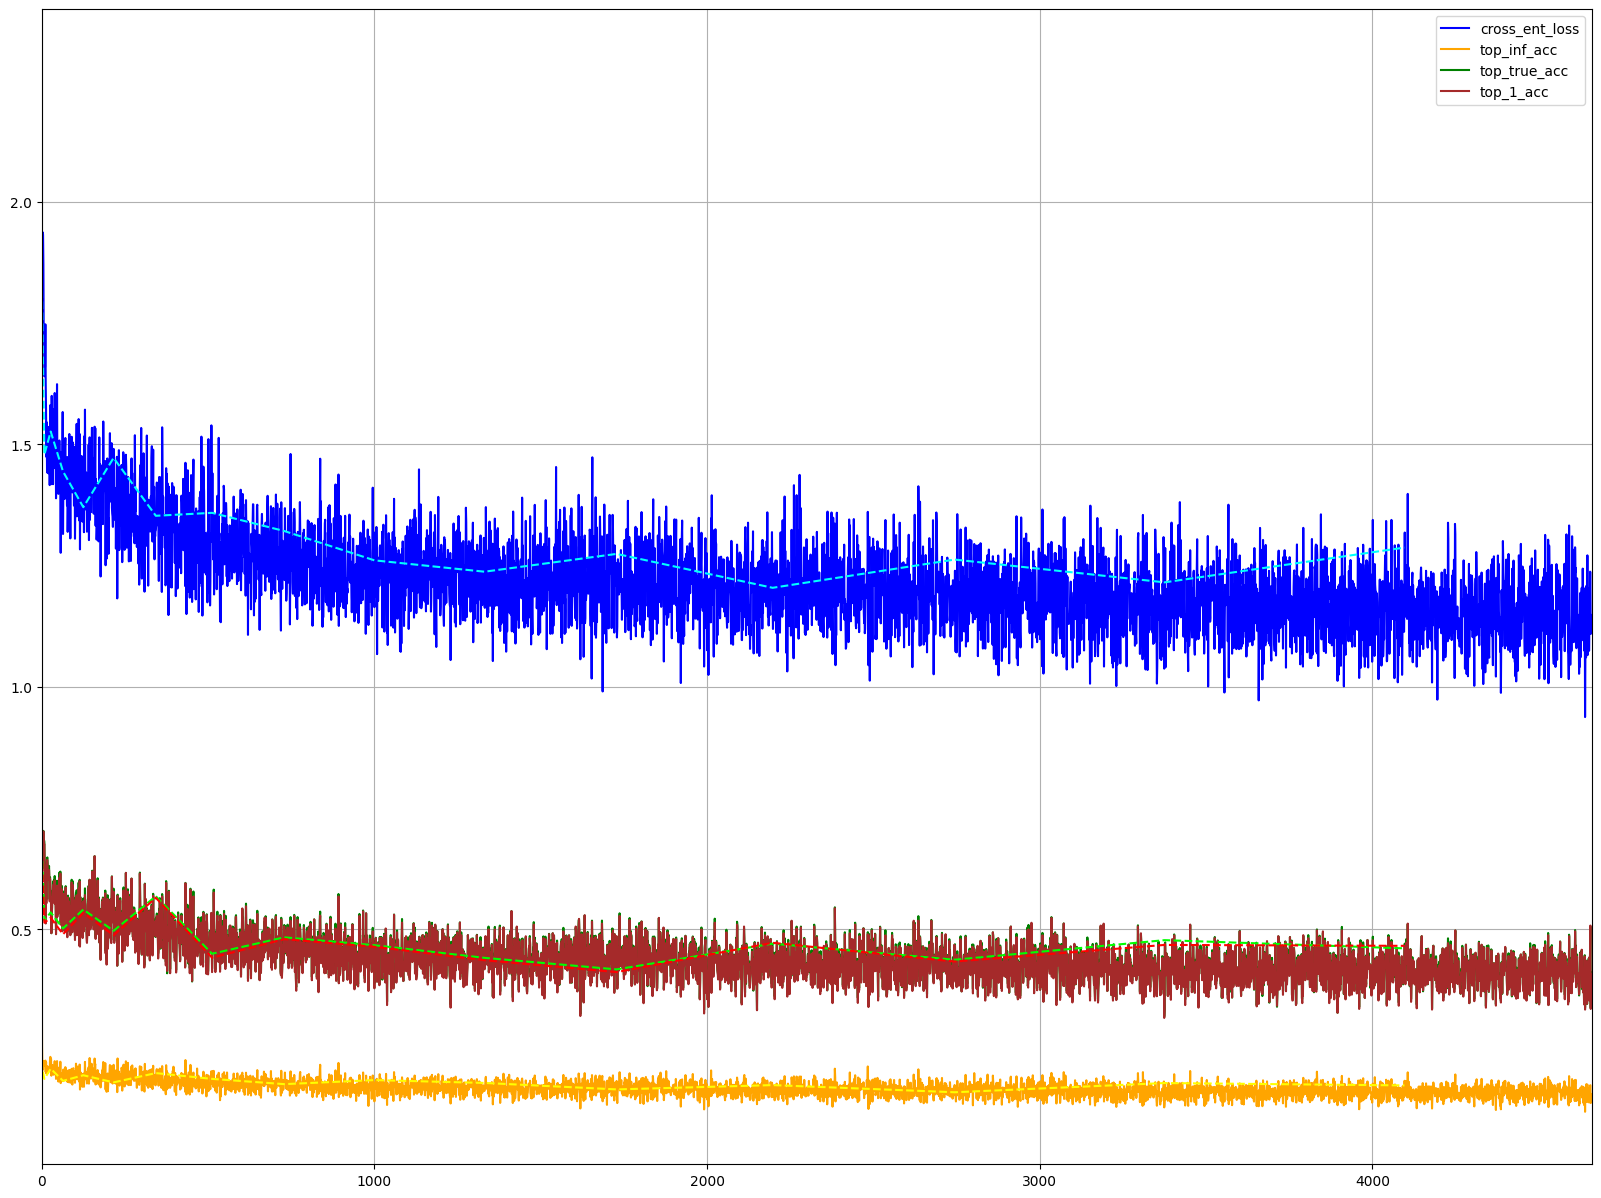

Note: metrics are on a 'lower is better basis' so accuracy metrics are actually '1 - x'


,Unnamed: 0,epoch,training_cross_ent_loss,training_top_inf_acc,training_top_true_acc,training_top_1_acc,val_cross_ent_loss,val_top_inf_acc,val_top_true_acc,val_top_1_acc
0,0,0,2.288779,0.462869,0.740234,0.745968,1.885785,0.274832,0.709635,0.704000
1,1,1,1.799392,0.257867,0.690104,0.682731,1.800382,0.215451,0.652344,0.644000
8,8,8,1.640394,0.225455,0.679688,0.675889,1.478827,0.191797,0.518229,0.513834
27,27,27,1.494474,0.214844,0.564453,0.561753,1.526460,0.212825,0.535156,0.524000
64,64,64,1.315241,0.187305,0.513021,0.511811,1.444194,0.187766,0.501953,0.489960
125,125,125,1.431865,0.200358,0.563802,0.558233,1.370512,0.199349,0.541016,0.534137
216,216,216,1.490765,0.220872,0.583984,0.577689,1.472123,0.184644,0.497179,0.488000
343,343,343,1.322846,0.183718,0.516276,0.515748,1.352764,0.203776,0.568359,0.565217
512,512,512,1.352193,0.182644,0.418945,0.412000,1.358837,0.191840,0.449870,0.441767
729,729,729,1.272345,0.188889,0.509115,0.506024,1.321373,0.180990,0.483724,0.479839


<Figure size 640x480 with 0 Axes>

In [2]:
plot_training_metrics(model_name)

In [3]:
data_tokens, train_dataset, val_dataset = model.load_datasets(model.params)


In [4]:
sample = val_dataset.sample_unpreprocessed()
model.predict_one(sample)

[Partial dataset] Train (343523) / validation (85881) ratio


ValueError: invalid literal for int() with base 10: 'mercuryhourglass'

Browsing though attention weights is one way to (hopefully...) better understand the decision making of the black box model. More on that: https://towardsdatascience.com/deconstructing-bert-part-2-visualizing-the-inner-workings-of-attention-60a16d86b5c1.

In [ ]:
model.get_attn_weights(3, 3)

Attention weights for layer #3/3, head #3/3.
This shows eg 'the output embedding (at row R) attends this much to input embeddings (at columns C)'
NOTE: our attention weights are such that an output embedding cannot attend to padding embeddings (which we effectively do not show in the table); also output embeddings of possessed relics and cards cannot attend to input embeddings of offered cards. cf our MHALayer implementation


,0 goldenidol,1 redskull,2 defend_r,3 defend_r,4 defend_r,5 defend_r,6 strike_r,7 strike_r,8 strike_r,9 strike_r,10 strike_r,11 bash,12 ascendersbane,13 berserk+1,14 shrugitoff,15 injury,16 metallicize,17 bludgeon,18 carnage,19 ironwave,20 bodyslam
0 goldenidol,0.119,0.142,0.018,0.018,0.018,0.018,0.037,0.037,0.037,0.037,0.037,0.030,0.025,0.034,0.094,0.061,0.090,0.146,0.000,0.000,0.000
1 redskull,0.056,0.104,0.017,0.016,0.016,0.016,0.081,0.081,0.081,0.081,0.081,0.022,0.019,0.058,0.059,0.064,0.055,0.093,0.000,0.000,0.000
2 defend_r,0.043,0.080,0.019,0.018,0.018,0.018,0.050,0.050,0.050,0.050,0.050,0.086,0.075,0.044,0.053,0.078,0.085,0.134,0.000,0.000,0.000
3 defend_r,0.044,0.081,0.018,0.017,0.017,0.017,0.048,0.048,0.048,0.048,0.048,0.090,0.073,0.047,0.051,0.077,0.089,0.141,0.000,0.000,0.000
4 defend_r,0.044,0.081,0.018,0.017,0.017,0.017,0.048,0.048,0.048,0.048,0.048,0.090,0.073,0.047,0.051,0.077,0.089,0.141,0.000,0.000,0.000
5 defend_r,0.044,0.081,0.018,0.017,0.017,0.017,0.048,0.048,0.048,0.048,0.048,0.090,0.073,0.047,0.051,0.077,0.089,0.141,0.000,0.000,0.000
6 strike_r,0.047,0.129,0.014,0.013,0.013,0.013,0.022,0.022,0.022,0.022,0.022,0.030,0.069,0.057,0.066,0.045,0.080,0.313,0.000,0.000,0.000
7 strike_r,0.047,0.129,0.014,0.013,0.013,0.013,0.022,0.022,0.022,0.022,0.022,0.030,0.069,0.057,0.066,0.045,0.080,0.313,0.000,0.000,0.000
8 strike_r,0.047,0.129,0.014,0.013,0.013,0.013,0.022,0.022,0.022,0.022,0.022,0.030,0.069,0.057,0.066,0.045,0.080,0.313,0.000,0.000,0.000
9 strike_r,0.047,0.129,0.014,0.013,0.013,0.013,0.022,0.022,0.022,0.022,0.022,0.030,0.069,0.057,0.066,0.045,0.080,0.313,0.000,0.000,0.000


This table may render badly (eg on github) so [here](doc/attention_table.png) is an example screenshot:

![here](doc/attention_table.png).

# 'win predictor' model

In [46]:
import os
import json

from sts_ml.model_abc import PARAMS_FILENAME
from sts_ml.train import TRAINING_DIR
from sts_ml.infer import plot_training_metrics, generate_metrics
from sts_ml.registry import instanciate_model

# model_name = "2023-02-26-13-45-20_WinModel_blocks4x256_split0.8_relics"
# model_name = "2023-03-11-17-29-08_WinModel_blocks4x256_split0.8_relics"
# model_name = "2023-03-11-17-39-23_WinModel_blocks4x256_split0.8_relics"
# model_name = "2023-03-11-19-05-42_WinModel_blocks4x256_split0.8_relics"
model_name = "2023-03-11-20-30-37_CardModel_blocks4x256_split0.8_relics"

training_dir = os.path.join(TRAINING_DIR, model_name)
model = instanciate_model(training_dir=training_dir, ckpt=2355)


Files train/val split is 8 / 2


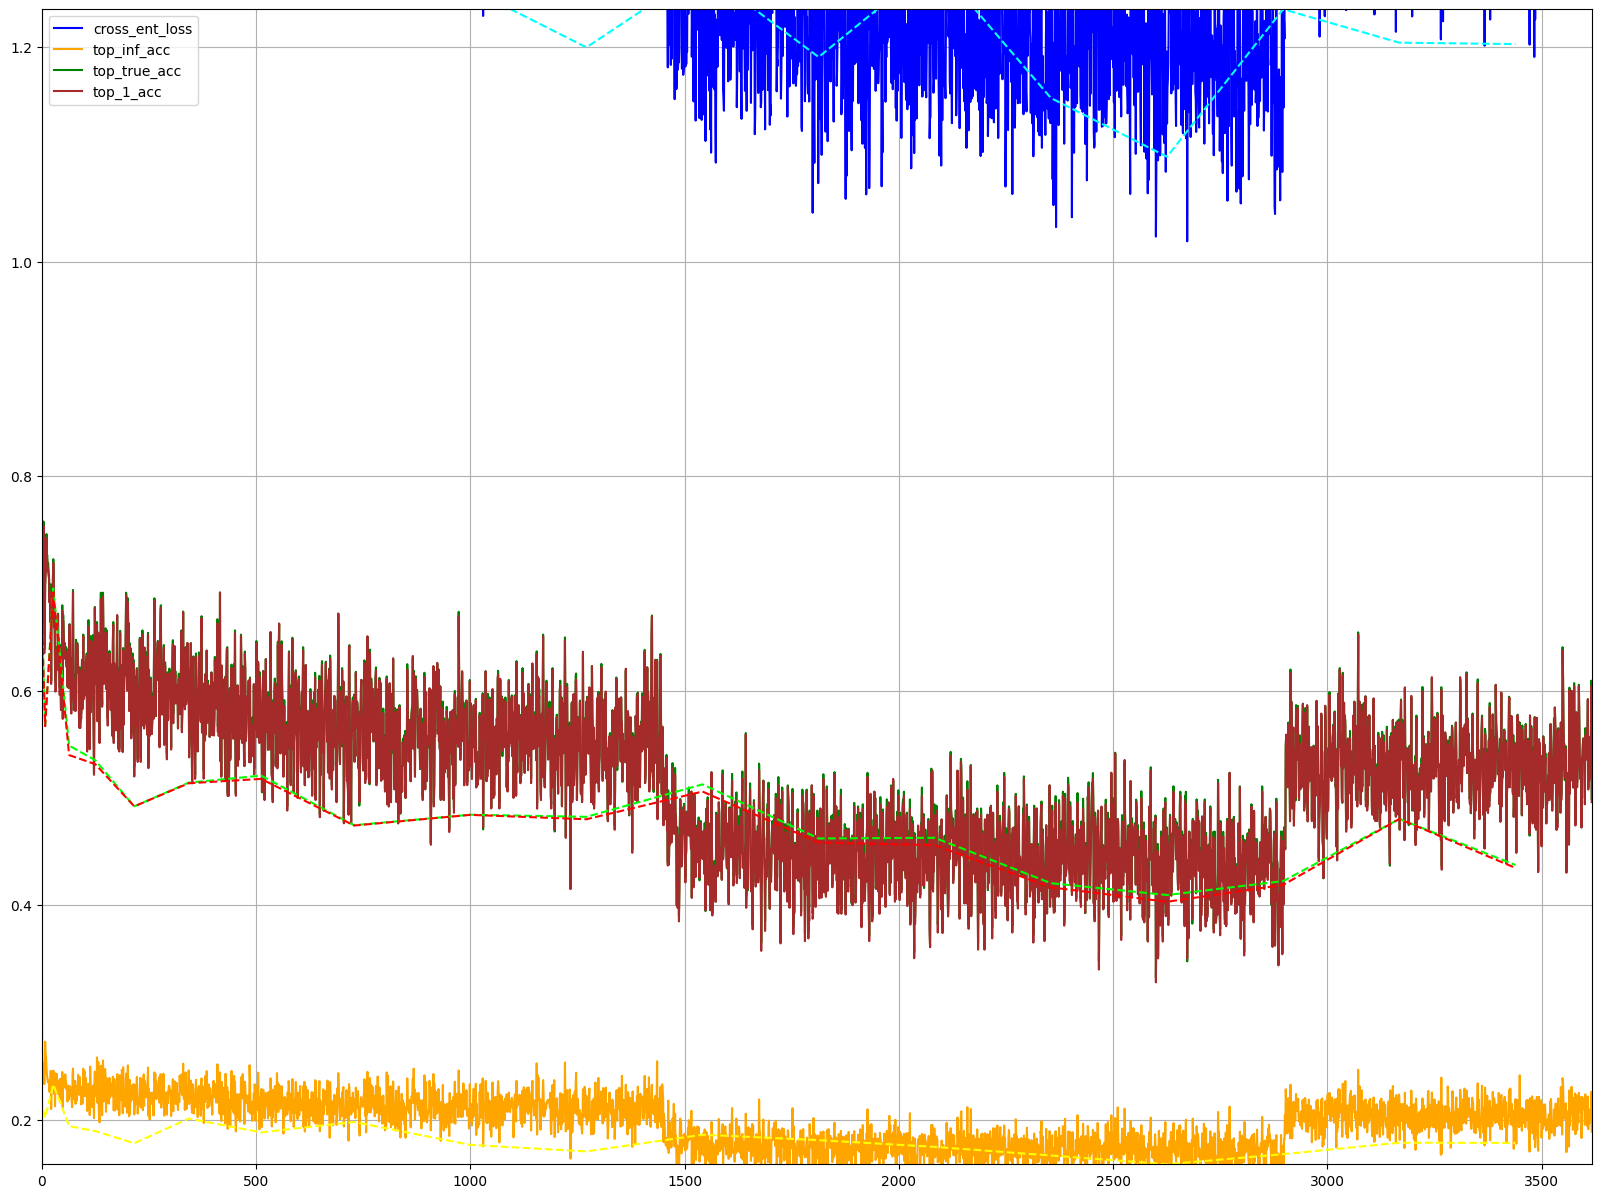

Note: metrics are on a 'lower is better basis' so accuracy metrics are actually '1 - x'


,Unnamed: 0,epoch,training_cross_ent_loss,training_top_inf_acc,training_top_true_acc,training_top_1_acc,val_cross_ent_loss,val_top_inf_acc,val_top_true_acc,val_top_1_acc
0,0,0,2.137686,0.446289,0.768750,0.768000,1.761384,0.229492,0.683594,0.681102
1,1,1,1.835787,0.254557,0.726562,0.726562,1.720924,0.212890,0.660156,0.657480
8,8,8,1.787813,0.272786,0.699219,0.698039,1.582019,0.201823,0.568359,0.566929
27,27,27,1.597078,0.245833,0.722656,0.719368,1.644971,0.232796,0.695312,0.691700
64,64,64,1.516449,0.222656,0.634766,0.633858,1.409965,0.194010,0.548828,0.540000
125,125,125,1.545372,0.226562,0.632812,0.631373,1.364728,0.189453,0.535156,0.531496
216,216,216,1.430223,0.204948,0.529297,0.520000,1.295655,0.178060,0.492188,0.492188
343,343,343,1.583438,0.246070,0.617188,0.608000,1.372676,0.201063,0.514323,0.513726
512,512,512,1.501914,0.225179,0.585503,0.581028,1.327940,0.188259,0.520833,0.517787
729,729,729,1.498979,0.219075,0.596354,0.596078,1.275891,0.197917,0.474609,0.474308


<Figure size 640x480 with 0 Axes>

In [47]:
plot_training_metrics(model_name)

In [48]:
data_tokens, train_dataset, val_dataset = model.load_datasets(model.params)


Files train/val split is 8 / 2
Files train/val split is 8 / 2


In [49]:
sample = val_dataset.sample_unpreprocessed()


[Partial dataset] 371293


In [51]:
ret = model.predict_one(sample)
model.get_attn_weights(3, 3)



              cards expert_scores predicted_scores
0          defend_r          deck             deck
1          defend_r          deck             deck
2          defend_r          deck             deck
3          defend_r          deck             deck
4          strike_r          deck             deck
5          strike_r          deck             deck
6          strike_r          deck             deck
7          strike_r          deck             deck
8          strike_r          deck             deck
9              bash          deck             deck
10    ascendersbane          deck             deck
11          panacea          deck             deck
12  perfectedstrike          deck             deck
13            clash          deck             deck
14         ironwave          deck             deck
15      doubletap+1          deck             deck
16             flex          deck             deck
17     spotweakness             0         0.476279
18        armaments            

,0 defend_r,1 defend_r,2 defend_r,3 defend_r,4 strike_r,5 strike_r,6 strike_r,7 strike_r,8 strike_r,9 bash,10 ascendersbane,11 panacea,12 perfectedstrike,13 clash,14 ironwave,15 doubletap+1,16 flex,17 ironwave,18 spotweakness,19 armaments
0 defend_r,0.022,0.022,0.022,0.020,0.014,0.014,0.014,0.014,0.014,0.008,0.017,0.012,0.004,0.002,0.005,0.042,0.014,0.003,0.006,0.006
1 defend_r,0.022,0.022,0.022,0.020,0.014,0.014,0.014,0.014,0.014,0.008,0.017,0.012,0.004,0.002,0.005,0.042,0.014,0.003,0.006,0.006
2 defend_r,0.022,0.022,0.022,0.020,0.014,0.014,0.014,0.014,0.014,0.008,0.017,0.012,0.004,0.002,0.005,0.042,0.014,0.003,0.006,0.006
3 defend_r,0.022,0.022,0.022,0.020,0.014,0.014,0.014,0.014,0.014,0.009,0.017,0.012,0.004,0.002,0.005,0.043,0.015,0.003,0.006,0.006
4 strike_r,0.015,0.015,0.015,0.014,0.013,0.013,0.013,0.013,0.013,0.014,0.050,0.007,0.007,0.013,0.011,0.035,0.067,0.007,0.024,0.007
5 strike_r,0.015,0.015,0.015,0.014,0.013,0.013,0.013,0.013,0.013,0.014,0.050,0.007,0.007,0.013,0.011,0.035,0.067,0.007,0.024,0.007
6 strike_r,0.015,0.015,0.015,0.014,0.013,0.013,0.013,0.013,0.013,0.014,0.050,0.007,0.007,0.013,0.011,0.035,0.067,0.007,0.024,0.007
7 strike_r,0.015,0.015,0.015,0.014,0.013,0.013,0.013,0.013,0.013,0.014,0.050,0.007,0.007,0.013,0.011,0.035,0.067,0.007,0.024,0.007
8 strike_r,0.015,0.015,0.015,0.014,0.013,0.013,0.013,0.013,0.013,0.014,0.050,0.007,0.007,0.013,0.011,0.035,0.067,0.007,0.024,0.007
9 bash,0.022,0.022,0.022,0.020,0.027,0.027,0.027,0.027,0.027,0.014,0.016,0.030,0.020,0.005,0.016,0.023,0.020,0.009,0.010,0.018


In [52]:
ret